In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns   
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
# import seglearn as sglearn        # For windowing and sequence modeling
import tsfresh     
import os
from sklearn.preprocessing import StandardScaler


 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import polars as pl
import dask.dataframe as dd
from pathlib import Path

# Data Exploration

In [2]:
# File paths for three training datasets
defog = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog')
notype = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype')
tdcsfog = Path('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog')

In [3]:
defog_files = [f for f in os.listdir(defog) if f.endswith('.csv')]

# List to store individual DataFrames
defog_list = []

for path in defog.glob("*.csv"):
    patient_id = path.stem  # removes .csv

    df = pl.read_csv(path)
    df = df.with_columns([
        pl.lit(patient_id).alias("patient_id")
    ])
    
    defog_list.append(df)

defog_df = pl.concat(defog_list)
# for f in defog_files:
#     file_path = os.path.join(defog, f)
#     df = pl.read_csv(file_path)
#     df = df.with_columns([
#         pl.lit(f).alias('file')  # Add filename as identifier
#     ])
#     defog_list.append(df)

# # Concatenate into one large DataFrame
# defog_df = pl.concat(defog_list)

In [4]:
defog_df.head()

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,patient_id
i64,f64,f64,f64,i64,i64,i64,bool,bool,str
0,-1.002697,0.022371,0.068304,0,0,0,false,false,"""be9d33541d"""
1,-1.002641,0.019173,0.066162,0,0,0,false,false,"""be9d33541d"""
2,-0.99982,0.019142,0.067536,0,0,0,false,false,"""be9d33541d"""
3,-0.998023,0.018378,0.068409,0,0,0,false,false,"""be9d33541d"""
4,-0.998359,0.016726,0.066448,0,0,0,false,false,"""be9d33541d"""


In [5]:
tdcsfog_files = [f for f in os.listdir(tdcsfog) if f.endswith('.csv')]

# List to store individual DataFrames
tdcsfog_list = []

for path in tdcsfog.glob("*.csv"):
    patient_id = path.stem  # removes .csv

    df = pl.read_csv(path)
    df = df.with_columns([
        pl.lit(patient_id).alias("patient_id")
    ])
    
    tdcsfog_list.append(df)

tdcsfog_df = pl.concat(tdcsfog_list)

In [6]:
tdcsfog_df.head()

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id
i64,f64,f64,f64,i64,i64,i64,str
0,-9.66589,0.04255,0.184744,0,0,0,"""a171e61840"""
1,-9.672969,0.049217,0.184644,0,0,0,"""a171e61840"""
2,-9.67026,0.03362,0.19379,0,0,0,"""a171e61840"""
3,-9.673356,0.035159,0.184369,0,0,0,"""a171e61840"""
4,-9.671458,0.043913,0.197814,0,0,0,"""a171e61840"""


In [7]:
print(defog_df.head())
# print(defog_df.info())
print(defog_df.describe())
print(defog_df.shape)     # (rows, columns)
print(defog_df.columns)   # list of column names
print(defog_df.dtypes)    # list of column types

shape: (5, 10)
┌──────┬───────────┬──────────┬──────────┬───┬─────────┬───────┬───────┬────────────┐
│ Time ┆ AccV      ┆ AccML    ┆ AccAP    ┆ … ┆ Walking ┆ Valid ┆ Task  ┆ patient_id │
│ ---  ┆ ---       ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---        │
│ i64  ┆ f64       ┆ f64      ┆ f64      ┆   ┆ i64     ┆ bool  ┆ bool  ┆ str        │
╞══════╪═══════════╪══════════╪══════════╪═══╪═════════╪═══════╪═══════╪════════════╡
│ 0    ┆ -1.002697 ┆ 0.022371 ┆ 0.068304 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 1    ┆ -1.002641 ┆ 0.019173 ┆ 0.066162 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 2    ┆ -0.99982  ┆ 0.019142 ┆ 0.067536 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 3    ┆ -0.998023 ┆ 0.018378 ┆ 0.068409 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 4    ┆ -0.998359 ┆ 0.016726 ┆ 0.066448 ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
└──────┴───────────┴──────────┴──────────┴───┴─────────┴───────┴───────┴────────────┘
shape: (9, 11)
┌───────────┬───────────

In [8]:
print(tdcsfog_df.head())
# print(tdcsfog_df.info())
print(tdcsfog_df.shape)     # (rows, columns)
print(tdcsfog_df.columns)   # list of column names
print(tdcsfog_df.dtypes) 
print(tdcsfog_df.describe())

shape: (5, 8)
┌──────┬───────────┬──────────┬──────────┬─────────────────┬──────┬─────────┬────────────┐
│ Time ┆ AccV      ┆ AccML    ┆ AccAP    ┆ StartHesitation ┆ Turn ┆ Walking ┆ patient_id │
│ ---  ┆ ---       ┆ ---      ┆ ---      ┆ ---             ┆ ---  ┆ ---     ┆ ---        │
│ i64  ┆ f64       ┆ f64      ┆ f64      ┆ i64             ┆ i64  ┆ i64     ┆ str        │
╞══════╪═══════════╪══════════╪══════════╪═════════════════╪══════╪═════════╪════════════╡
│ 0    ┆ -9.66589  ┆ 0.04255  ┆ 0.184744 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 1    ┆ -9.672969 ┆ 0.049217 ┆ 0.184644 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 2    ┆ -9.67026  ┆ 0.03362  ┆ 0.19379  ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 3    ┆ -9.673356 ┆ 0.035159 ┆ 0.184369 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
│ 4    ┆ -9.671458 ┆ 0.043913 ┆ 0.197814 ┆ 0               ┆ 0    ┆ 0       ┆ a171e61840 │
└──────┴───────────┴──────────┴──────────┴─────────────────┴──────┴─────────

In [9]:
events_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/events.csv')
print(events_df.head())
print(events_df.shape)   
print(events_df.columns)   
print(events_df.dtypes) 
print(events_df.describe())

           Id      Init  Completion  Type  Kinetic
0  003f117e14   8.61312     14.7731  Turn      1.0
1  009ee11563  11.38470     41.1847  Turn      1.0
2  009ee11563  54.66470     58.7847  Turn      1.0
3  011322847a  28.09660     30.2966  Turn      1.0
4  01d0fe7266  30.31840     31.8784  Turn      1.0
(3544, 5)
Index(['Id', 'Init', 'Completion', 'Type', 'Kinetic'], dtype='object')
Id             object
Init          float64
Completion    float64
Type           object
Kinetic       float64
dtype: object
              Init   Completion      Kinetic
count  3544.000000  3544.000000  2502.000000
mean    956.298418   964.489046     0.817746
std     946.357201   943.968560     0.386131
min     -30.669000   -29.719000     0.000000
25%      39.518175    48.610800     1.000000
50%     768.656500   774.261000     1.000000
75%    1570.300000  1576.697250     1.000000
max    4381.217000  4392.745000     1.000000


In [10]:
unique_defog_patients = defog_df["patient_id"].unique()

print(unique_defog_patients)

shape: (91,)
Series: 'patient_id' [str]
[
	"13a4fe5159"
	"bf2fd0ff35"
	"be15a0d6c5"
	"32843e32b6"
	"06414383cf"
	…
	"aafcbecb5a"
	"15508c7f41"
	"f0b8335d50"
	"092b4c1819"
	"8d2d863dfd"
]


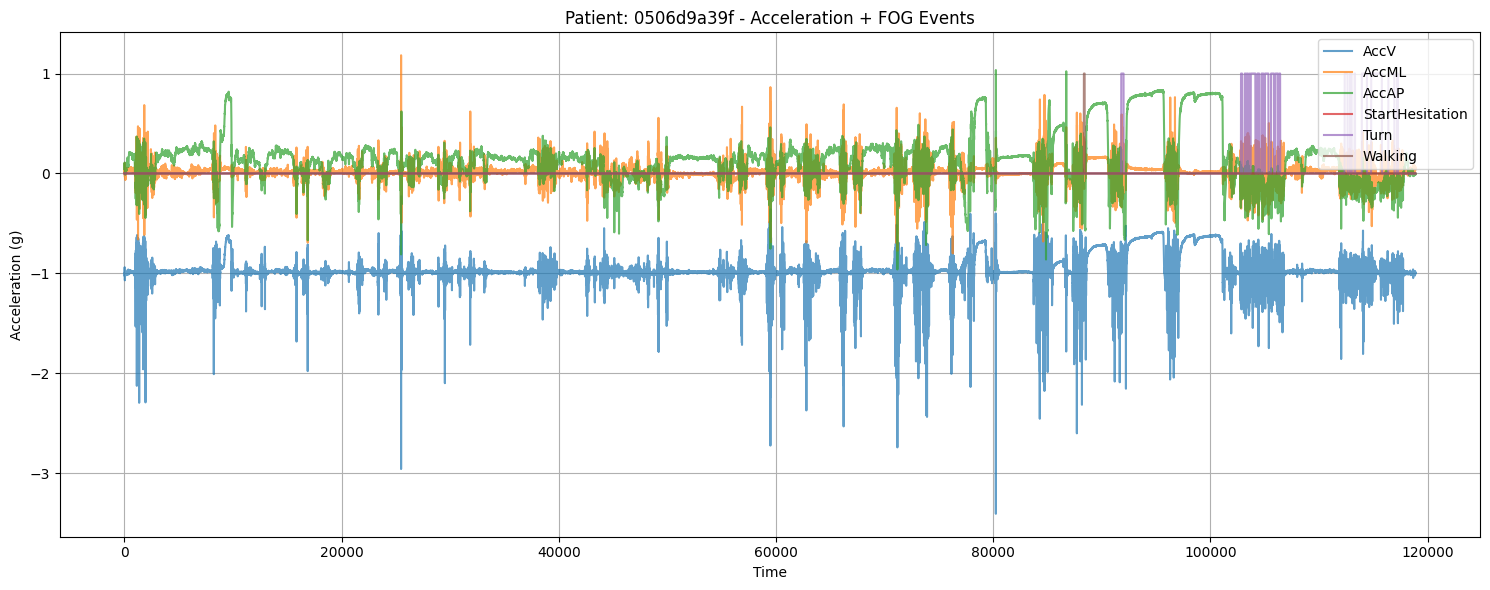

In [11]:
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == 'be9d33541d').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)
plt.plot(df['Time'], df['Turn'], label='Turn', alpha=0.7)
plt.plot(df['Time'], df['Walking'], label='Walking', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Data Cleaning

In [12]:
# Data types of features 
print(f'DEFOG DATA TYPES:\n{defog_df.dtypes}\n')
print(f'TDCSFOG DATA TYPES:\n{tdcsfog_df.dtypes}\n')

DEFOG DATA TYPES:
[Int64, Float64, Float64, Float64, Int64, Int64, Int64, Boolean, Boolean, String]

TDCSFOG DATA TYPES:
[Int64, Float64, Float64, Float64, Int64, Int64, Int64, String]



In [13]:
print(tdcsfog_df.null_count())

shape: (1, 8)
┌──────┬──────┬───────┬───────┬─────────────────┬──────┬─────────┬────────────┐
│ Time ┆ AccV ┆ AccML ┆ AccAP ┆ StartHesitation ┆ Turn ┆ Walking ┆ patient_id │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆ ---             ┆ ---  ┆ ---     ┆ ---        │
│ u32  ┆ u32  ┆ u32   ┆ u32   ┆ u32             ┆ u32  ┆ u32     ┆ u32        │
╞══════╪══════╪═══════╪═══════╪═════════════════╪══════╪═════════╪════════════╡
│ 0    ┆ 0    ┆ 0     ┆ 0     ┆ 0               ┆ 0    ┆ 0       ┆ 0          │
└──────┴──────┴───────┴───────┴─────────────────┴──────┴─────────┴────────────┘


In [14]:
# Convert accerlations in defog to m/s^2
G_CONVERSION = 9.80665
defog_df[["AccV", "AccML", "AccAP"]] *= G_CONVERSION
print(defog_df)

shape: (13_525_702, 10)
┌────────┬───────────┬──────────┬───────────┬───┬─────────┬───────┬───────┬────────────┐
│ Time   ┆ AccV      ┆ AccML    ┆ AccAP     ┆ … ┆ Walking ┆ Valid ┆ Task  ┆ patient_id │
│ ---    ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---     ┆ ---   ┆ ---   ┆ ---        │
│ i64    ┆ f64       ┆ f64      ┆ f64       ┆   ┆ i64     ┆ bool  ┆ bool  ┆ str        │
╞════════╪═══════════╪══════════╪═══════════╪═══╪═════════╪═══════╪═══════╪════════════╡
│ 0      ┆ -9.833101 ┆ 0.219382 ┆ 0.669832  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 1      ┆ -9.832554 ┆ 0.188024 ┆ 0.648829  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 2      ┆ -9.804885 ┆ 0.187721 ┆ 0.662298  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 3      ┆ -9.787264 ┆ 0.180227 ┆ 0.670866  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ 4      ┆ -9.790555 ┆ 0.164025 ┆ 0.651633  ┆ … ┆ 0       ┆ false ┆ false ┆ be9d33541d │
│ …      ┆ …         ┆ …        ┆ …         ┆ … ┆ …       ┆ …     ┆ …     ┆ …         

In [15]:
# Convert the Valid and Task Columns to Integer Columns
def convert_valid_and_t(df):
    df = df.with_columns(
        pl.col("Valid").cast(pl.Int8).alias("Valid")
    )
    
    df = df.with_columns(
        pl.col("Task").cast(pl.Int8).alias("Task")
    )
    return df
defog_df = convert_valid_and_t(defog_df)
# tdcsfog_df = convert_valid_and_t(tdcsfog_df)


print(defog_df)

shape: (13_525_702, 10)
┌────────┬───────────┬──────────┬───────────┬───┬─────────┬───────┬──────┬────────────┐
│ Time   ┆ AccV      ┆ AccML    ┆ AccAP     ┆ … ┆ Walking ┆ Valid ┆ Task ┆ patient_id │
│ ---    ┆ ---       ┆ ---      ┆ ---       ┆   ┆ ---     ┆ ---   ┆ ---  ┆ ---        │
│ i64    ┆ f64       ┆ f64      ┆ f64       ┆   ┆ i64     ┆ i8    ┆ i8   ┆ str        │
╞════════╪═══════════╪══════════╪═══════════╪═══╪═════════╪═══════╪══════╪════════════╡
│ 0      ┆ -9.833101 ┆ 0.219382 ┆ 0.669832  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 1      ┆ -9.832554 ┆ 0.188024 ┆ 0.648829  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 2      ┆ -9.804885 ┆ 0.187721 ┆ 0.662298  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 3      ┆ -9.787264 ┆ 0.180227 ┆ 0.670866  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ 4      ┆ -9.790555 ┆ 0.164025 ┆ 0.651633  ┆ … ┆ 0       ┆ 0     ┆ 0    ┆ be9d33541d │
│ …      ┆ …         ┆ …        ┆ …         ┆ … ┆ …       ┆ …     ┆ …    ┆ …          │
│ 109120

In [16]:
# Create a new column that contains the acceleration magnitude
def acc_magnitude(df):
    df = df.with_columns(
        (
            (pl.col("AccV") ** 2 + pl.col("AccML") ** 2 + pl.col("AccAP") ** 2).sqrt()
        ).alias("Acc_MAGNITUDE")
    )

    return df

tdcsfog_df = acc_magnitude(tdcsfog_df)
defog_df = acc_magnitude(defog_df)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,patient_id,Acc_MAGNITUDE
i64,f64,f64,f64,i64,i64,i64,i8,i8,str,f64
0,-9.833101,0.219382,0.669832,0,0,0,0,0,"""be9d33541d""",9.85833
1,-9.832554,0.188024,0.648829,0,0,0,0,0,"""be9d33541d""",9.855732
2,-9.804885,0.187721,0.662298,0,0,0,0,0,"""be9d33541d""",9.829021
3,-9.787264,0.180227,0.670866,0,0,0,0,0,"""be9d33541d""",9.811885
4,-9.790555,0.164025,0.651633,0,0,0,0,0,"""be9d33541d""",9.813587
…,…,…,…,…,…,…,…,…,…,…
109120,-9.210807,0.30954,-3.871049,0,0,0,0,0,"""06414383cf""",9.99599
109121,-9.228995,0.309714,-3.850343,0,0,0,0,0,"""06414383cf""",10.004769
109122,-9.219534,0.285297,-3.867594,0,0,0,0,0,"""06414383cf""",10.001974


In [17]:
# Standardize acceleration per patient for each training dataframe
def standardize_acc_by_patient(df: pl.DataFrame):
    acc_cols = ['AccV', 'AccML', 'AccAP']
    for col in acc_cols:
        df = df.with_columns(
            (
                (pl.col(col) - pl.col(col).mean().over("patient_id")) /
                pl.col(col).std().over("patient_id")
            ).alias(col)  # overwrite original column
        )
    return df

tdcsfog_df = standardize_acc_by_patient(tdcsfog_df)
defog_df = standardize_acc_by_patient(defog_df)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,patient_id,Acc_MAGNITUDE
i64,f64,f64,f64,i64,i64,i64,i8,i8,str,f64
0,-0.375372,0.093954,-0.32069,0,0,0,0,0,"""be9d33541d""",9.85833
1,-0.374921,0.053599,-0.329435,0,0,0,0,0,"""be9d33541d""",9.855732
2,-0.352097,0.053208,-0.323827,0,0,0,0,0,"""be9d33541d""",9.829021
3,-0.337562,0.043565,-0.32026,0,0,0,0,0,"""be9d33541d""",9.811885
4,-0.340277,0.022714,-0.328268,0,0,0,0,0,"""be9d33541d""",9.813587
…,…,…,…,…,…,…,…,…,…,…
109120,0.108433,0.126815,-0.645129,0,0,0,0,0,"""06414383cf""",9.99599
109121,0.078984,0.12706,-0.6384,0,0,0,0,0,"""06414383cf""",10.004769
109122,0.094303,0.092946,-0.644006,0,0,0,0,0,"""06414383cf""",10.001974


In [18]:
# Band-pass Filter 
def infer_fs(time_seconds: np.ndarray) -> float:
    dt = np.diff(np.asarray(time_seconds, dtype=float))
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        raise ValueError("Cannot infer sampling frequency from Time column.")
    return 1.0 / np.median(dt)

def design_bandpass(low_hz: float, high_hz: float, fs: float, order: int = 4):
    nyq = fs / 2.0
    low = max(1e-6, low_hz / nyq)
    high = min(0.999999, high_hz / nyq)
    if not (0 < low < high < 1):
        raise ValueError(f"Invalid band for fs={fs:.3f}Hz: low={low_hz}Hz, high={high_hz}Hz")
    b, a = butter(order, [low, high], btype="band")
    return b, a

def bandpass_series(y: pd.Series, b, a) -> np.ndarray:
    sig = pd.to_numeric(y, errors="coerce").interpolate(limit_direction="both").to_numpy(float)
    return filtfilt(b, a, sig, method="pad")

def bandpass_dataframe(df: pd.DataFrame, cols=('AccV','AccML','AccAP'),
                       low_hz=0.1, high_hz=30.0, order=4) -> pd.DataFrame:
    out = df.copy()
    # Only keep columns that exist
    cols = tuple([c for c in cols if c in out.columns])
    if len(cols) == 0:
        return out

    fs = infer_fs(out['Time'].to_numpy())
    b, a = design_bandpass(low_hz, high_hz, fs, order)
    for col in cols:
        out[f"{col}_bp"] = bandpass_series(out[col], b, a)
    return out



In [19]:
# Apply Band-pass to all patients 
def add_bandpass_to_all_patients(pl_df: pl.DataFrame,
                                 cols=('AccV','AccML','AccAP'),
                                 low_hz=0.1, high_hz=30.0, order=4) -> pl.DataFrame:
    if "patient_id" not in pl_df.columns:
        raise ValueError("Expected a 'patient_id' column.")

    out_chunks = []
    # Unique patient list
    patient_ids = pl_df.select("patient_id").unique().to_series().to_list()

    for pid in patient_ids:
        g = pl_df.filter(pl.col("patient_id") == pid).to_pandas()
        # Skip tiny or malformed groups
        if "Time" not in g.columns or len(g) < 5:
            out_chunks.append(pl.from_pandas(g))  # just pass through
            continue

        try:
            g_bp = bandpass_dataframe(g, cols=cols, low_hz=low_hz, high_hz=high_hz, order=order)
        except Exception as e:
            print(f"[WARN] Skipping bandpass for patient {pid}: {e}")
            g_bp = g  # pass through raw if something fails

        out_chunks.append(pl.from_pandas(g_bp))

    return pl.concat(out_chunks, how="vertical_relaxed")

defog_df_bp   = add_bandpass_to_all_patients(defog_df,   cols=('AccV','AccML','AccAP'),
                                             low_hz=0.1, high_hz=30.0, order=4)
tdcsfog_df_bp = add_bandpass_to_all_patients(tdcsfog_df, cols=('AccV','AccML','AccAP'),
                                             low_hz=0.1, high_hz=30.0, order=4)

print("DEFOG with band-pass columns:", [c for c in defog_df_bp.columns if c.endswith("_bp")][:6], "...")
print("TDCSFOG with band-pass columns:", [c for c in tdcsfog_df_bp.columns if c.endswith("_bp")][:6], "...")

DEFOG with band-pass columns: ['AccV_bp', 'AccML_bp', 'AccAP_bp'] ...
TDCSFOG with band-pass columns: ['AccV_bp', 'AccML_bp', 'AccAP_bp'] ...


# Plot Magnitude 

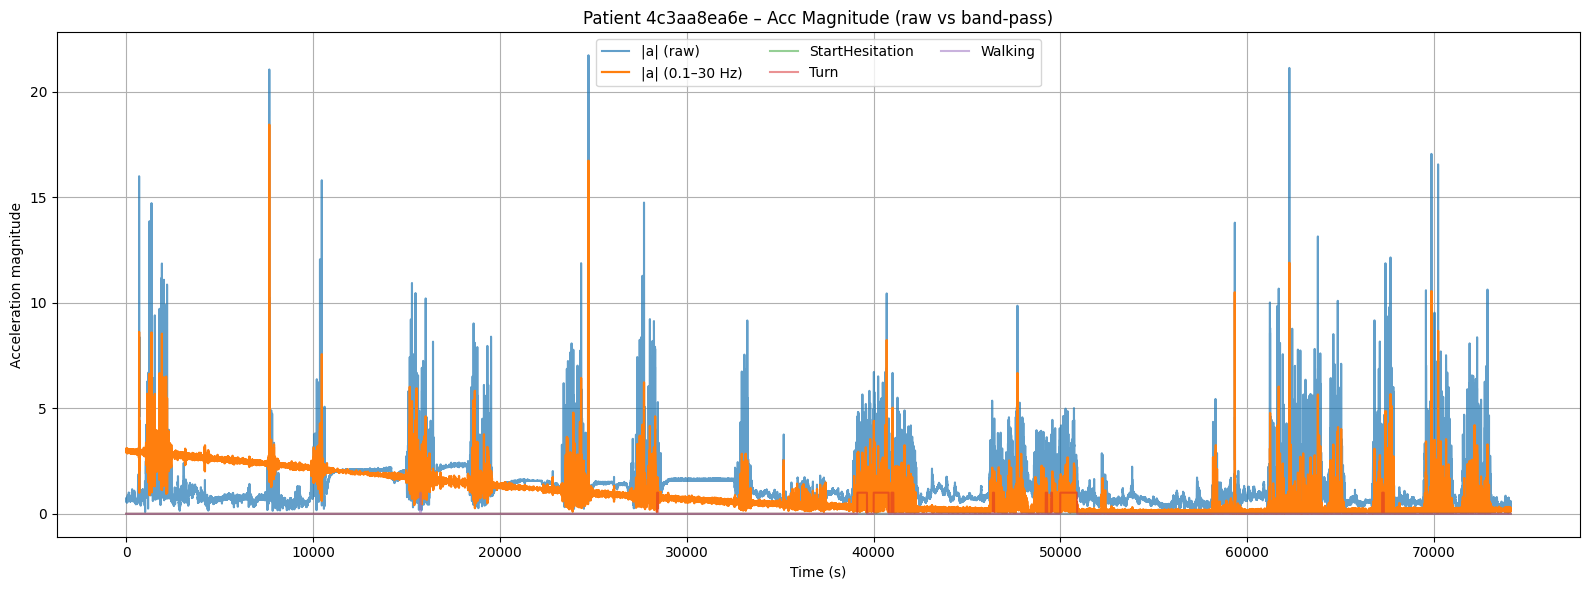

In [20]:
def add_magnitude_cols(pl_df: pl.DataFrame) -> pl.DataFrame: 
    out = pl_df.with_columns(
        ((pl.col("AccV")**2 + pl.col("AccML")**2 + pl.col("AccAP")**2).sqrt()).alias("AccMag")
    )
    bp_cols = {"AccV_bp", "AccML_bp", "AccAP_bp"}
    if bp_cols.issubset(set(out.columns)):
        out = out.with_columns(
            ((pl.col("AccV_bp")**2 + pl.col("AccML_bp")**2 + pl.col("AccAP_bp")**2).sqrt()).alias("AccMag_bp")
        )
    return out 
    
def plot_patient_mag(pl_df: pl.DataFrame, patient_id: str,
                     time_col: str = "Time",
                     show_events: bool = True,
                     title_suffix: str = ""):
    dfp = pl_df.filter(pl.col("patient_id") == patient_id).to_pandas()
    if not {"AccMag", time_col}.issubset(dfp.columns):
        raise ValueError("Missing magnitude or time column")
    plt.figure(figsize=(16,6))
    plt.plot(dfp[time_col], dfp["AccMag"], label="|a| (raw)", alpha=0.7)
    if "AccMag_bp" in dfp.columns:
        plt.plot(dfp[time_col], dfp["AccMag_bp"], label="|a| (0.1–30 Hz)", linewidth=1.6)
    if show_events:
        for ev in ["StartHesitation", "Turn", "Walking"]:
            if ev in dfp.columns:
                plt.plot(dfp[time_col], dfp[ev], label=ev, alpha=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration magnitude")
    plt.title(f"Patient {patient_id} – Acc Magnitude {title_suffix}")
    plt.legend(ncol=3)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Add magnitude columns to dataframes
defog_df_bp = add_magnitude_cols(defog_df_bp)
tdcsfog_df_bp = add_magnitude_cols(tdcsfog_df_bp)
defog_df = add_magnitude_cols(defog_df)
tdcsfog_df = add_magnitude_cols(tdcsfog_df)

# Plot magnitude for one patient
plot_patient_mag(defog_df_bp, patient_id="4c3aa8ea6e", title_suffix="(raw vs band-pass)")


In [21]:
# Create a new column that contains Time as seconds
def time_to_seconds(df, hertz):
    df = df.with_columns(
        (
            (pl.col("Time") / hertz)
        ).alias("Time (seconds)")
    )

    return df

tdcsfog_df = time_to_seconds(tdcsfog_df, 128)
defog_df = time_to_seconds(tdcsfog_df, 100)
defog_df

Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,patient_id,Acc_MAGNITUDE,AccMag,Time (seconds)
i64,f64,f64,f64,i64,i64,i64,str,f64,f64,f64
0,-0.083911,0.203213,-0.67943,0,0,0,"""a171e61840""",9.667749,0.714116,0.0
1,-0.089146,0.208098,-0.679487,0,0,0,"""a171e61840""",9.674856,0.716208,0.01
2,-0.087143,0.196669,-0.674231,0,0,0,"""a171e61840""",9.67226,0.707715,0.02
3,-0.089432,0.197797,-0.679645,0,0,0,"""a171e61840""",9.675176,0.71347,0.03
4,-0.088028,0.204211,-0.671919,0,0,0,"""a171e61840""",9.67358,0.707762,0.04
…,…,…,…,…,…,…,…,…,…,…
5153,-0.463118,0.20755,-1.838585,0,0,0,"""0506d9a39f""",9.979921,1.907341,51.53
5154,-0.305387,0.236566,-1.834007,0,0,0,"""0506d9a39f""",9.757885,1.874248,51.54
5155,-0.201991,0.21319,-1.832518,0,0,0,"""0506d9a39f""",9.61317,1.855902,51.55


In [22]:
# Check for outliers from acceleration
def detect_outliers(df: pl.DataFrame):
    acc_cols = ['AccV', 'AccML', 'AccAP']
    for col in acc_cols: 
        z_col = col
        outlier_df = df.filter(pl.col(z_col).abs() > 3.0)
    return outlier_df
print(detect_outliers(defog_df))
print(detect_outliers(tdcsfog_df))

shape: (92_179, 11)
┌──────┬───────────┬───────────┬───────────┬───┬────────────┬─────────────┬──────────┬─────────────┐
│ Time ┆ AccV      ┆ AccML     ┆ AccAP     ┆ … ┆ patient_id ┆ Acc_MAGNITU ┆ AccMag   ┆ Time        │
│ ---  ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---        ┆ DE          ┆ ---      ┆ (seconds)   │
│ i64  ┆ f64       ┆ f64       ┆ f64       ┆   ┆ str        ┆ ---         ┆ f64      ┆ ---         │
│      ┆           ┆           ┆           ┆   ┆            ┆ f64         ┆          ┆ f64         │
╞══════╪═══════════╪═══════════╪═══════════╪═══╪════════════╪═════════════╪══════════╪═════════════╡
│ 1910 ┆ -1.290404 ┆ 1.618016  ┆ 3.612224  ┆ … ┆ a171e61840 ┆ 13.787228   ┆ 4.163086 ┆ 19.1        │
│ 1911 ┆ -2.917139 ┆ 2.923083  ┆ 3.496609  ┆ … ┆ a171e61840 ┆ 15.868035   ┆ 5.411135 ┆ 19.11       │
│ 1924 ┆ -2.735014 ┆ 0.30849   ┆ -3.010618 ┆ … ┆ a171e61840 ┆ 13.806283   ┆ 4.079129 ┆ 19.24       │
│ 1925 ┆ -3.089478 ┆ 0.467506  ┆ -3.192343 ┆ … ┆ a171e61840 ┆ 14.360474

## Visualize Acceleration  Signals During FoG Events

In [23]:
# Get unique patient IDs with a StartHesitation, Turn, and Walking event
# Take a subset of 3 patients for each event
StartHesPatients = (
    defog_df.filter(pl.col("StartHesitation") == 1)
            .select("patient_id")
            .unique()
            .to_series()[:3]  # take first 3
)
print(f"Patients with Start Hesitation: {StartHesPatients.to_list()}")

TurnPatients = (
    defog_df.filter(pl.col("Turn") == 1)
            .select("patient_id")
            .unique()
            .to_series()[:3]
)
print(f"Patients with Turn: {TurnPatients.to_list()}")

WalkingPatients = (
    defog_df.filter(pl.col("Walking") == 1)
            .select("patient_id")
            .unique()
            .to_series()[:3]
)
print(f"Patients with Walking: {WalkingPatients.to_list()}")

Patients with Start Hesitation: ['d98358a75f', 'be8fdfa712', '8661ef6281']
Patients with Turn: ['10efee36af', 'ba9343dc51', '9fc94b7eb6']
Patients with Walking: ['150e8227fc', '3291d59f24', '8969714d63']


In [24]:
# Get unique patient IDs with a StartHesitation, Turn, and Walking event 
# (including band-pass)
if {"StartHesitation","Turn","Walking"}.issubset(set(defog_df_bp.columns)):
    StartHesPatients = (
        defog_df_bp.filter(pl.col("StartHesitation") == 1)
                   .select("patient_id").unique().to_series()[:3]
    )
    TurnPatients = (
        defog_df_bp.filter(pl.col("Turn") == 1)
                   .select("patient_id").unique().to_series()[:3]
    )
    WalkingPatients = (
        defog_df_bp.filter(pl.col("Walking") == 1)
                   .select("patient_id").unique().to_series()[:3]
    )
    print(f"Patients with Start Hesitation: {StartHesPatients.to_list()}")
    print(f"Patients with Turn: {TurnPatients.to_list()}")
    print(f"Patients with Walking: {WalkingPatients.to_list()}")

Patients with Start Hesitation: ['e069a57511', '68e7e02a47', '0d7ab3a9f9']
Patients with Turn: ['e069a57511', '4c3aa8ea6e', 'daa4d27db4']
Patients with Walking: ['95e9824e15', '4ec23c3d98', '7030643376']


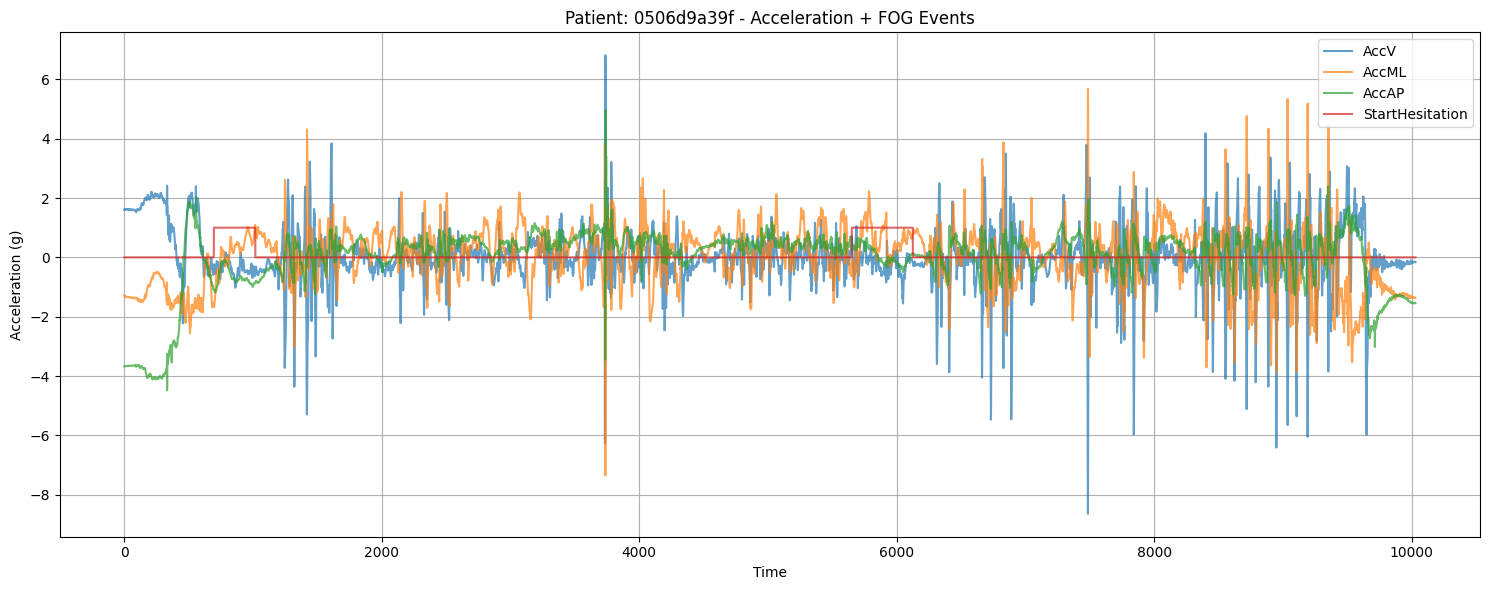

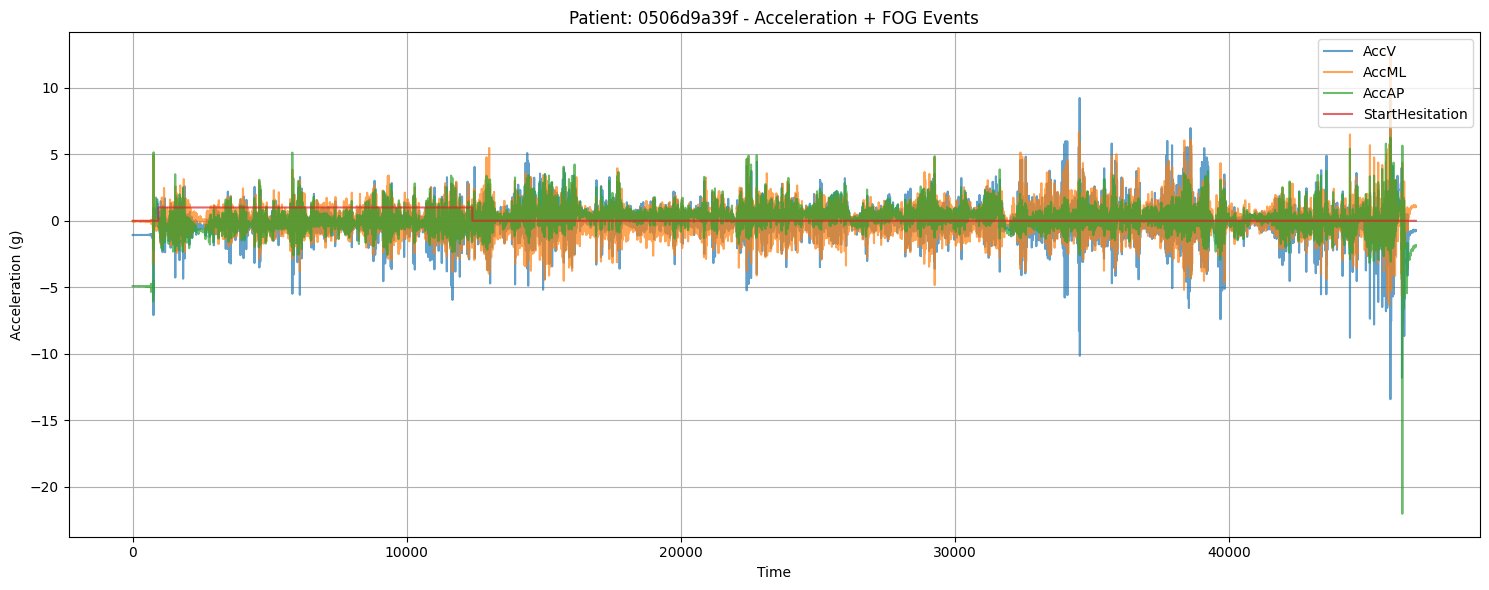

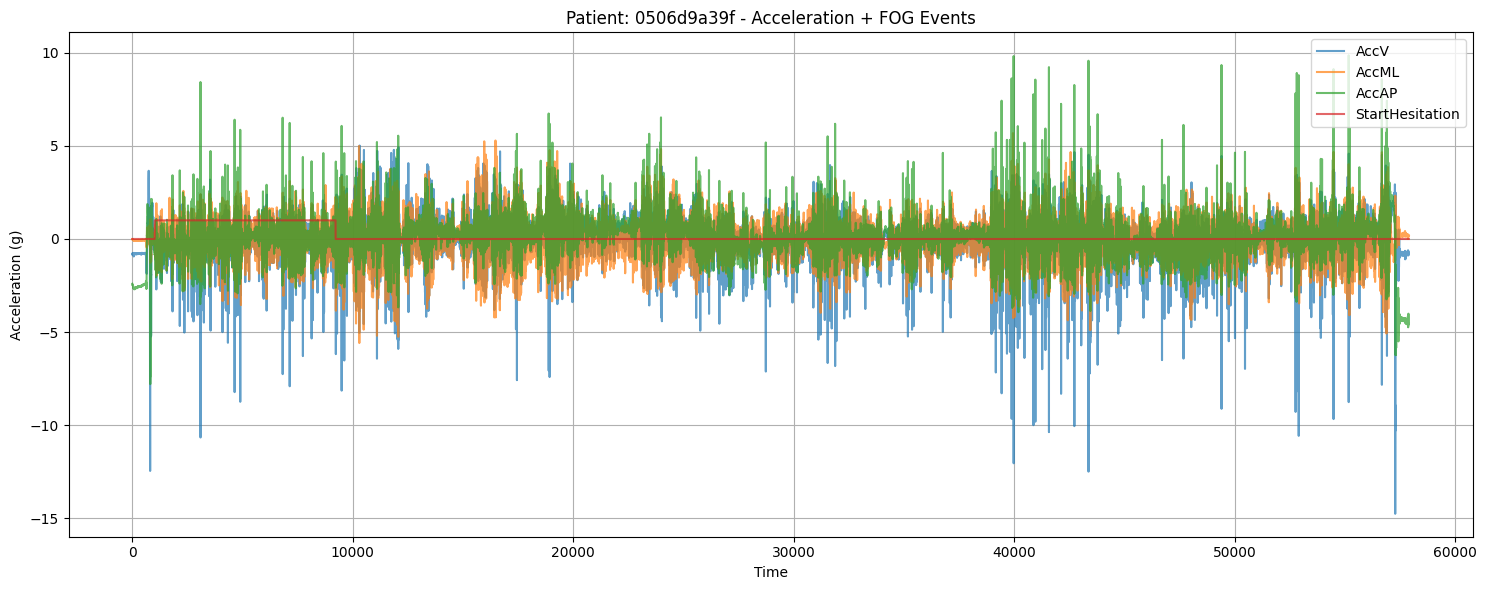

In [25]:
# Start Hestitation
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == '81262644e7').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Start Hestitation
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == '3ba3590a08').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()



# Start Hestitation
# 1. Filter your Polars DF for a single patient and convert to pandas
df = defog_df.filter(pl.col("patient_id") == 'd98358a75f').to_pandas()

# 2. Plot
plt.figure(figsize=(15, 6))

# Plot acceleration
plt.plot(df['Time'], df['AccV'], label='AccV', alpha=0.7)
plt.plot(df['Time'], df['AccML'], label='AccML', alpha=0.7)
plt.plot(df['Time'], df['AccAP'], label='AccAP', alpha=0.7)

# 3. Plot events
plt.plot(df['Time'], df['StartHesitation'], label='StartHesitation', alpha=0.7)


# 4. Final touches
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title(f"Patient: {patient_id} - Acceleration + FOG Events")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract Time Domain Features 

In [26]:
def extract_time_features_pd(
    df: pd.DataFrame,
    fs: float,
    win_s: float,
    hop_s: float,
    signal_cols=('AccX','AccY','AccZ','GyroX','GyroY','GyroZ'),
    label_cols=None,                 # e.g. ['StartHesitation','Turn','Walking','Event']
    id_cols=None,                    # e.g. ['subject_id','series_id','id'] to carry through
):
    df = df.copy()
    n = len(df)
    win = int(round(fs*win_s))
    hop = int(round(fs*hop_s))
    if win <= 0 or hop <= 0:
        raise ValueError("win_s and hop_s must be > 0")

    # Pre-pull arrays for speed
    X = df.loc[:, signal_cols].to_numpy(dtype=float)

    # Helper feature fns (safe on NaNs/empties)
    def feats_one(w):
        f = {}
        # basic stats
        f.update({f'{c}_mean': np.nanmean(w[:,i]) for i,c in enumerate(signal_cols)})
        f.update({f'{c}_var' : np.nanvar (w[:,i]) for i,c in enumerate(signal_cols)})
        f.update({f'{c}_std' : np.nanstd (w[:,i]) for i,c in enumerate(signal_cols)})
        f.update({f'{c}_min' : np.nanmin (w[:,i]) for i,c in enumerate(signal_cols)})
        f.update({f'{c}_max' : np.nanmax (w[:,i]) for i,c in enumerate(signal_cols)})
        f.update({f'{c}_median': np.nanmedian(w[:,i]) for i,c in enumerate(signal_cols)})
        f.update({f'{c}_iqr': np.nanpercentile(w[:,i],75)-np.nanpercentile(w[:,i],25) for i,c in enumerate(signal_cols)})

        # energy & rms
        f.update({f'{c}_energy': np.nansum(np.square(w[:,i]))/len(w) for i,c in enumerate(signal_cols)})
        f.update({f'{c}_rms'   : np.sqrt(np.nanmean(np.square(w[:,i]))) for i,c in enumerate(signal_cols)})

        # skew & kurt
        for i,c in enumerate(signal_cols):
            col = w[:,i]
            f[f'{c}_skew'] = skew(col, nan_policy='omit', bias=False)
            f[f'{c}_kurt'] = kurtosis(col, nan_policy='omit', fisher=True, bias=False)

        # vector features for tri-axial groups
        if set(['AccX','AccY','AccZ']).issubset(signal_cols):
            ax = [signal_cols.index('AccX'), signal_cols.index('AccY'), signal_cols.index('AccZ')]
            acc = w[:,ax]
            mag = np.sqrt(np.sum(acc**2, axis=1))
            f['Acc_mag_mean'] = np.nanmean(mag)
            f['Acc_mag_std']  = np.nanstd(mag)
            # Signal Magnitude Area (SMA)
            f['Acc_sma'] = (np.nansum(np.abs(acc), axis=0).sum()) / len(mag)

            # correlations
            for (a,b) in [('AccX','AccY'),('AccX','AccZ'),('AccY','AccZ')]:
                i1, i2 = signal_cols.index(a), signal_cols.index(b)
                col1, col2 = w[:,i1], w[:,i2]
                if np.all(np.isfinite(col1)) and np.all(np.isfinite(col2)) and len(col1) > 1:
                    f[f'corr_{a}_{b}'] = np.corrcoef(col1, col2)[0,1]
                else:
                    f[f'corr_{a}_{b}'] = np.nan

        if set(['GyroX','GyroY','GyroZ']).issubset(signal_cols):
            gx = [signal_cols.index('GyroX'), signal_cols.index('GyroY'), signal_cols.index('GyroZ')]
            gyro = w[:,gx]
            mag = np.sqrt(np.sum(gyro**2, axis=1))
            f['Gyro_mag_mean'] = np.nanmean(mag)
            f['Gyro_mag_std']  = np.nanstd(mag)
            f['Gyro_sma'] = (np.nansum(np.abs(gyro), axis=0).sum()) / len(mag)
            for (a,b) in [('GyroX','GyroY'),('GyroX','GyroZ'),('GyroY','GyroZ')]:
                i1, i2 = signal_cols.index(a), signal_cols.index(b)
                col1, col2 = w[:,i1], w[:,i2]
                if np.all(np.isfinite(col1)) and np.all(np.isfinite(col2)) and len(col1) > 1:
                    f[f'corr_{a}_{b}'] = np.corrcoef(col1, col2)[0,1]
                else:
                    f[f'corr_{a}_{b}'] = np.nan

        return f

    rows = []
    start_idx = 0
    win_id = 0
    while start_idx + win <= n:
        end_idx = start_idx + win
        w = X[start_idx:end_idx, :]
        feat = feats_one(w)
        # add time/window metadata
        feat['win_id'] = win_id
        feat['t_start_s'] = start_idx / fs
        feat['t_end_s']   = (end_idx-1) / fs

        # bring-through IDs from the *end* row of the window (common in DEFoG baselines)
        if id_cols:
            for c in id_cols:
                feat[c] = df.iloc[end_idx-1][c]

        # aggregate labels if provided (ANY>0 inside window)
        if label_cols:
            sub = df.iloc[start_idx:end_idx]
            feat['label_any'] = bool((sub[label_cols].fillna(0).to_numpy() > 0).any())
            for c in label_cols:
                feat[f'label_{c}'] = bool((sub[c].fillna(0).to_numpy() > 0).any())

        rows.append(feat)
        win_id += 1
        start_idx += hop

    return pd.DataFrame(rows)

In [27]:
DATA_DIR = Path("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train")

print("Available training folders:", [p.name for p in DATA_DIR.iterdir()])

Available training folders: ['defog', 'tdcsfog', 'notype']


In [28]:
tdcsfog_file = list((DATA_DIR / "tdcsfog").glob("*.csv"))[0]
defog_file   = list((DATA_DIR / "defog").glob("*.csv"))[0]
notype_file  = list((DATA_DIR / "notype").glob("*.csv"))[0]

print("Sample files chosen:")
print("tdcsfog:", tdcsfog_file.name)
print("defog:", defog_file.name)
print("notype:", notype_file.name)

Sample files chosen:
tdcsfog: a171e61840.csv
defog: be9d33541d.csv
notype: 1e8d55d48d.csv


In [29]:

tdcsfog_df = pd.read_csv(tdcsfog_file)
defog_df   = pd.read_csv(defog_file)
notype_df  = pd.read_csv(notype_file)

In [30]:
import re

def tdcsfog_time_features(df, fs=128.0, win_s=2.0, hop_s=0.5):
    """
    Extract time-domain features from accelerometer data in tdcsfog_df.
    Works purely in pandas.
    """

    # --- auto-detect accelerometer columns ---
    cols = list(df.columns)
    lower = {c.lower(): c for c in cols}
    candidates = [
        ['AccX','AccY','AccZ'],
        ['AccelX','AccelY','AccelZ'],
        ['acc_x','acc_y','acc_z'],
        ['AccV','AccML','AccAP'],
        ['accv','accml','accap'],
    ]
    acc_cols = None
    for trio in candidates:
        found = [lower.get(c.lower()) for c in trio]
        if all(found):
            acc_cols = found
            break
    if acc_cols is None:
        acc_cols = [c for c in cols if re.search('acc', c, re.I)][:3]
    if len(acc_cols) < 3:
        raise KeyError(f"Could not find 3 accelerometer columns. Found: {acc_cols}")

    # --- label columns ---
    label_cols = [c for c in ['StartHesitation','Turn','Walking'] if c in df.columns]

    # --- window setup ---
    win = int(round(fs * win_s))
    hop = int(round(fs * hop_s))
    n = len(df)

    X = df[acc_cols].to_numpy(dtype=float)
    rows = []
    start = 0
    win_id = 0

    while start + win <= n:
        end = start + win
        W = X[start:end, :]
        f = {}

        # per-axis features
        for i, c in enumerate(acc_cols):
            w = W[:, i]
            f[f'{c}_mean']   = np.nanmean(w)
            f[f'{c}_std']    = np.nanstd(w)
            f[f'{c}_var']    = np.nanvar(w)
            f[f'{c}_min']    = np.nanmin(w)
            f[f'{c}_max']    = np.nanmax(w)
            f[f'{c}_median'] = np.nanmedian(w)
            q75, q25 = np.nanpercentile(w, [75, 25])
            f[f'{c}_iqr']    = q75 - q25
            f[f'{c}_energy'] = np.nansum(w**2) / len(w)
            f[f'{c}_rms']    = np.sqrt(np.nanmean(w**2))
            f[f'{c}_skew']   = skew(w, nan_policy='omit', bias=False)
            f[f'{c}_kurt']   = kurtosis(w, nan_policy='omit', fisher=True, bias=False)

        # vector magnitude features
        mag = np.sqrt(np.sum(W**2, axis=1))
        f['Acc_mag_mean'] = np.nanmean(mag)
        f['Acc_mag_std']  = np.nanstd(mag)
        f['Acc_sma']      = np.nansum(np.abs(W)) / len(W)

        # correlations
        def corr_safe(a,b):
            if len(a) > 1 and np.isfinite(a).all() and np.isfinite(b).all():
                return np.corrcoef(a,b)[0,1]
            return np.nan
        f[f'corr_{acc_cols[0]}_{acc_cols[1]}'] = corr_safe(W[:,0], W[:,1])
        f[f'corr_{acc_cols[0]}_{acc_cols[2]}'] = corr_safe(W[:,0], W[:,2])
        f[f'corr_{acc_cols[1]}_{acc_cols[2]}'] = corr_safe(W[:,1], W[:,2])

        # labels (if exist)
        if label_cols:
            sub = df.iloc[start:end][label_cols].fillna(0).to_numpy()
            f['label_any'] = bool((sub > 0).any())
            for j, c in enumerate(label_cols):
                f[f'label_{c}'] = bool((sub[:, j] > 0).any())

        # window metadata
        f['win_id'] = win_id
        f['t_start_s'] = start / fs
        f['t_end_s']   = (end - 1) / fs

        rows.append(f)
        win_id += 1
        start += hop

    return pd.DataFrame(rows)

In [31]:
# parameters
FS = 128.0
WIN = 2.0   # 2 seconds per window
HOP = 0.5   # 0.5-second step

tdcsfog_feats = tdcsfog_time_features(tdcsfog_df, fs=FS, win_s=WIN, hop_s=HOP)

print("Detected accelerometer columns:", [c for c in tdcsfog_feats.columns if 'mean' in c][:3])
print("Shape:", tdcsfog_feats.shape)
tdcsfog_feats.head()

Detected accelerometer columns: ['AccV_mean', 'AccML_mean', 'AccAP_mean']
Shape: (112, 46)


,AccV_mean,AccV_std,AccV_var,AccV_min,AccV_max,AccV_median,AccV_iqr,AccV_energy,AccV_rms,AccV_skew,...,corr_AccV_AccML,corr_AccV_AccAP,corr_AccML_AccAP,label_any,label_StartHesitation,label_Turn,label_Walking,win_id,t_start_s,t_end_s
0,-9.676408,0.006617,0.000044,-9.694637,-9.659135,-9.676250,0.009232,93.632915,9.676410,0.050714,...,-0.017974,0.029742,0.048487,False,False,False,False,0,0.0,1.992188
1,-9.676400,0.006681,0.000045,-9.694637,-9.659135,-9.676654,0.009463,93.632758,9.676402,0.044396,...,0.005490,-0.003859,-0.119356,False,False,False,False,1,0.5,2.492188
2,-9.675996,0.006480,0.000042,-9.693737,-9.659135,-9.675782,0.008877,93.624931,9.675998,0.030831,...,-0.022001,0.057198,-0.154278,False,False,False,False,2,1.0,2.992188
3,-9.677018,0.006550,0.000043,-9.693737,-9.659135,-9.677447,0.008826,93.644711,9.677020,0.154207,...,-0.070649,0.158226,-0.169971,False,False,False,False,3,1.5,3.492188
4,-9.678382,0.006107,0.000037,-9.693737,-9.660702,-9.679372,0.006954,93.671120,9.678384,0.272114,...,-0.019138,0.080240,-0.089752,False,False,False,False,4,2.0,3.992188


# Extract Frequency Domain Features 
*  The Fourier Transform is a mathematical tool that takes a complex signal and breaks it down nto its individual frequency components. It tells us what frequencies make up the signal and how strong each one is.
*  Time Domain features (mean, std, min, max, variance, median) shoes how a signal changes over time while a frequency domain feature (domiant frequency, spectral enegy, PSD) shows what frequencies make up the signal and how fast or periodic the motion is. 

In [32]:
# from scipy.signal import welch 

# def extract_freq_features(df, cols=('AccV', 'AccML', 'AccAP', 'Acc_MAGNITUDE'), fs=60):
    # features = {}

    # Look thorugh each acceleration in column 
    # for col in cols: 
        # if col not in df.columns: 
            # continue 
    # Convert column to a clean numpy array (remove Nans)
    # signal = df[col].dropna().to_numpy()

    # Skip if there's not enough signal data (avoid errors)
    # if len(signal) < 10: 
        # continue

    # Fourier Transform 

# Feature Engineering

In [33]:
# Add in Jerk Column


In [34]:
# Rolling Features